# High Voltage Standing Wave RF Cavity Simulator

* Our goal is to make a successful representation of the RF Cavity behavior for changing T[K], Pulse Width, Pulser Period, Voltage Gradient(HV level compared to ground) and relative timelapse.

## Dependencies

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

## Model

### Coefficients

In [ ]:
# Constants
R = 8.314  # Gas constant J/(mol*K)
molar_mass_air = 0.029  # kg/mol
specific_heat_air = 1005  # J/(kg*K)
initial_pressure = 101325 * 1e-5  # bar (1 atm)
initial_temperature = 300  # K (room temperature)
initial_volume = 1  # m^3
base_saturation_pressure = 4  # mbar (base value for saturation pressure)
base_saturation_temperature = 400  # K (base value for saturation temperature)
initial_gradient_threshold = 2e-5  # Threshold for gradient check
gradient_threshold = initial_gradient_threshold  # Threshold for gradient check
peak_pressure_amplitude = 3e1  # Amplitude for random pressure peaks mbar

# Simulation parameters

voltages = [10, 15, 20, 25, 30, 35, 40, 45]  # Volts
periods = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]  # seconds
widths = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]  # seconds

T_coeff = 0.01  # temperature coefficient
initial_P_coeff = 0.001  # initial pressure coefficient
P_coeff = initial_P_coeff  # pressure coefficient
time_span_excitation = (0, 1000)  # total excitation simulation time in seconds
time_span_relaxation = (0, 1000) # total relaxation_simulation time in seconds
eval_pts = 50  # number of evaluation points (normally 100k, for observation make 5k)
time_eval_excitation = np.linspace(time_span_excitation[0], time_span_excitation[1], eval_pts)  # evaluation points
time_eval_relaxation = np.linspace(time_span_relaxation[0], time_span_relaxation[1], eval_pts)  # evaluation points
time_lapse = 0

# Container to collect the results
all_time = []
all_pressure = []
all_temperature = []
all_width = []
all_period = []
all_voltage = []

# Iterate over all combinations of voltage, period, and width
MAX_P_COEFF = 1e-1
MAX_GRADIENT_THRESHOLD = 1e-2

### Model Function

In [ ]:
"""

# Toy RF Model
class RFModel:
    def __init__(self,
                 initial_pressure: float,
                 initial_temperature: float,
                 base_saturation_pressure: float,
                 base_saturation_temperature: float,
                 T_coeff: float,
                 P_coeff: float,
                 gradient_threshold: float,
                 peak_pressure_amplitude: float) -> None:
        self.initial_pressure = initial_pressure
        self.initial_temperature = initial_temperature
        self.base_saturation_pressure = base_saturation_pressure
        self.base_saturation_temperature = base_saturation_temperature
        self.T_coeff = T_coeff
        self.P_coeff = P_coeff
        self.gradient_threshold = gradient_threshold
        self.peak_pressure_amplitude = peak_pressure_amplitude

    def increase_phase(self, t, y, voltage:float, period, width):
        pressure, temperature = y
        width = width * 1e3
        period = period * 1e2
        voltage = voltage
        # Adjust saturation levels based on voltage, period, and width
        saturation_pressure = self.base_saturation_pressure + (0.04 * voltage) + (0.02 * period * width) # 0.04 and 0.02 randomly given, find relation from literature
        saturation_temperature = self.base_saturation_temperature + (0.5* voltage) + (0.2 * period * width) # 0.5 and 0.2 randomly given, find relation from literature

        # Calculate the temperature change due to RF power
        T_increase = self.P_coeff * voltage *  (1/ width) * (1/ period)
        temperature += T_increase  # Update temperature

        # Calculate the pressure change due to RF power
        P_increase = self.T_coeff * voltage * (1/ width) * (1/ period)

        # Logistic pressure and temperature change towards saturation
        dP_dt = self.P_coeff * pressure * (1 - pressure / saturation_pressure) + P_increase
        dT_dt = self.T_coeff * temperature * (1 - temperature / saturation_temperature) + T_increase

        # Gradient check for threshold gradient values introduce random peaks
        if np.abs(dP_dt) < self.gradient_threshold:
            dP_dt += self.peak_pressure_amplitude * np.abs(np.random.random())

        return [dP_dt, dT_dt]

    def relaxation_phase(self, t, y, relaxation_coeff_base=0.01):
        pressure, temperature = y
        dP_dt = -relaxation_coeff_base * (pressure - self.initial_pressure)
        dT_dt = -relaxation_coeff_base * (temperature - self.initial_temperature)
        return [dP_dt, dT_dt]

"""

'\n\n# Toy RF Model\nclass RFModel:\n    def __init__(self,\n                 initial_pressure: float,\n                 initial_temperature: float,\n                 base_saturation_pressure: float,\n                 base_saturation_temperature: float,\n                 T_coeff: float,\n                 P_coeff: float,\n                 gradient_threshold: float,\n                 peak_pressure_amplitude: float) -> None:\n        self.initial_pressure = initial_pressure\n        self.initial_temperature = initial_temperature\n        self.base_saturation_pressure = base_saturation_pressure\n        self.base_saturation_temperature = base_saturation_temperature\n        self.T_coeff = T_coeff\n        self.P_coeff = P_coeff\n        self.gradient_threshold = gradient_threshold\n        self.peak_pressure_amplitude = peak_pressure_amplitude\n\n    def increase_phase(self, t, y, voltage:float, period, width):\n        pressure, temperature = y\n        width = width * 1e3\n        period

In [ ]:
# Updated Toy RF Model
class RFModel:
    def __init__(self,
                 initial_pressure: float,
                 initial_temperature: float,
                 base_saturation_pressure: float,
                 base_saturation_temperature: float,
                 T_coeff: float,
                 P_coeff: float,
                 gradient_threshold: float,
                 peak_pressure_amplitude: float) -> None:
        self.initial_pressure = initial_pressure
        self.initial_temperature = initial_temperature
        self.base_saturation_pressure = base_saturation_pressure
        self.base_saturation_temperature = base_saturation_temperature
        self.T_coeff = T_coeff
        self.P_coeff = P_coeff
        self.gradient_threshold = gradient_threshold
        self.peak_pressure_amplitude = peak_pressure_amplitude

    def increase_phase(self, t, y, voltage: float, period, width):
        pressure, temperature = y
        width = width * 1e3
        period = period * 1e2
        voltage = voltage

        # Adjust saturation levels based on voltage, period, and width
        saturation_pressure = self.base_saturation_pressure + (0.04 * voltage) + (0.02 * period * width)
        saturation_temperature = self.base_saturation_temperature + (0.5 * voltage) + (0.2 * period * width)

        # Calculate the temperature change due to RF power
        T_increase = self.P_coeff * voltage * (1 / width) * (1 / period)
        temperature += T_increase  # Update temperature

        # Calculate the pressure change due to RF power
        P_increase = self.T_coeff * voltage * (1 / width) * (1 / period)

        # Logistic pressure and temperature change towards saturation
        dP_dt = self.P_coeff * pressure * (1 - pressure / saturation_pressure) + P_increase
        dT_dt = self.T_coeff * temperature * (1 - temperature / saturation_temperature) + T_increase

        # Gradient check for threshold gradient values introduce random peaks
        if np.abs(dP_dt) < self.gradient_threshold:
            # Add random peak
            random_peak = self.peak_pressure_amplitude * np.abs(np.random.random())
            dP_dt += random_peak

            # Apply a cap to the pressure change to avoid overflow
            max_dP_dt = 10 * self.P_coeff * self.initial_pressure  # Adjust multiplier as needed
            dP_dt = np.clip(dP_dt, -max_dP_dt, max_dP_dt)

            # Optionally, decay the random peak for stability
            decay_factor = 0.95  # Adjust decay for smoother peak handling
            dP_dt *= decay_factor

        return [dP_dt, dT_dt]

    def relaxation_phase(self, t, y, relaxation_coeff_base=0.01):
        pressure, temperature = y

        # Logistic decay back to initial conditions
        dP_dt = -relaxation_coeff_base * (pressure - self.initial_pressure)
        dT_dt = -relaxation_coeff_base * (temperature - self.initial_temperature)

        return [dP_dt, dT_dt]


### Run

In [ ]:
for i, voltage in enumerate(voltages):
    for j, period in enumerate(periods):
        for k, width in enumerate(widths):
            initial_conditions = [initial_pressure, initial_temperature]
            base_saturation_pressure = 3
            base_saturation_pressure = base_saturation_pressure + i + j + k
            P_coeff = round(min(initial_P_coeff + (k + 2 * j + 3 * i) * initial_P_coeff, MAX_P_COEFF),4)
            gradient_threshold = round(min(initial_gradient_threshold + 3 * i * initial_gradient_threshold + 2 * j * initial_gradient_threshold + 1 * k * initial_gradient_threshold, MAX_GRADIENT_THRESHOLD),4)

            # Debug prints
            print(f"Iteration (i={i}, j={j}, k={k}): P_coeff={P_coeff}, gradient_threshold={gradient_threshold}")

            # Initialize the RFModel class
            rf_model = RFModel(initial_pressure, initial_temperature, base_saturation_pressure, base_saturation_temperature, T_coeff, P_coeff, gradient_threshold, peak_pressure_amplitude)

            # Solve increase phase
            increase_solution = solve_ivp(rf_model.increase_phase, time_span_excitation, initial_conditions, args=(voltage, period, width), t_eval=time_eval_excitation, method='LSODA')
            increase_time = increase_solution.t
            increase_pressure = increase_solution.y[0]
            increase_temperature = increase_solution.y[1]

            # Use the final state of the increase phase as the initial state for the relaxation phase
            final_state = [increase_pressure[-1], increase_temperature[-1]]

            # Solve relaxation phase
            relaxation_solution = solve_ivp(rf_model.relaxation_phase, time_span_relaxation, final_state, t_eval=time_eval_relaxation, method='LSODA')
            relaxation_time = relaxation_solution.t
            relaxation_pressure = relaxation_solution.y[0]
            relaxation_temperature = relaxation_solution.y[1]

            # Combine results
            combined_time = np.concatenate([increase_time + time_lapse, relaxation_time + time_lapse + time_span_relaxation[1]])
            combined_pressure = np.concatenate([increase_pressure, relaxation_pressure])
            combined_temperature = np.concatenate([increase_temperature, relaxation_temperature])

            time_lapse += time_span_excitation[1] +  time_span_relaxation[1] # time_lapse += 2 * time_span[1] (+) time_span_ex[1] for excitation and time_span_rel relaxation

            all_time.append(combined_time)
            all_pressure.append(combined_pressure)
            all_temperature.append(combined_temperature)
            all_width.append(width)
            all_period.append(period)
            all_voltage.append(voltage)

# Adjust lengths for plotting or analysis
all_voltage = np.repeat(all_voltage,2* eval_pts) # 2 for excitation and relaxation
all_width = np.repeat(all_width,2* eval_pts) # 2 for excitation and relaxation
all_period = np.repeat(all_period,2* eval_pts) # 2 for excitation and relaxation

Iteration (i=0, j=0, k=0): P_coeff=0.001, gradient_threshold=0.0
Iteration (i=0, j=0, k=1): P_coeff=0.002, gradient_threshold=0.0
Iteration (i=0, j=0, k=2): P_coeff=0.003, gradient_threshold=0.0001
Iteration (i=0, j=0, k=3): P_coeff=0.004, gradient_threshold=0.0001
Iteration (i=0, j=0, k=4): P_coeff=0.005, gradient_threshold=0.0001
Iteration (i=0, j=0, k=5): P_coeff=0.006, gradient_threshold=0.0001
Iteration (i=0, j=0, k=6): P_coeff=0.007, gradient_threshold=0.0001
Iteration (i=0, j=0, k=7): P_coeff=0.008, gradient_threshold=0.0002
Iteration (i=0, j=1, k=0): P_coeff=0.003, gradient_threshold=0.0001
Iteration (i=0, j=1, k=1): P_coeff=0.004, gradient_threshold=0.0001
Iteration (i=0, j=1, k=2): P_coeff=0.005, gradient_threshold=0.0001
Iteration (i=0, j=1, k=3): P_coeff=0.006, gradient_threshold=0.0001
Iteration (i=0, j=1, k=4): P_coeff=0.007, gradient_threshold=0.0001
Iteration (i=0, j=1, k=5): P_coeff=0.008, gradient_threshold=0.0002
Iteration (i=0, j=1, k=6): P_coeff=0.009, gradient_thr

In [ ]:
# Concatenate results for plotting
all_time = np.concatenate(all_time)
all_pressure = np.concatenate(all_pressure)
all_temperature = np.concatenate(all_temperature)
all_width = np.array(all_width)
all_period = np.array(all_period)
all_voltage = np.array(all_voltage)

# For easy visualization and training, dataframe creation
data = {
    'Time (s)': all_time,
    'Pressure (mbar)': all_pressure,
    'Temperature (K)': all_temperature,
    'Pulse Width (s)': all_width,
    'Pulse Period (s)': all_period,
    'Voltage (V)': all_voltage
}
df = pd.DataFrame(data)

In [ ]:
df

,Time (s),Pressure (mbar),Temperature (K),Pulse Width (s),Pulse Period (s),Voltage (V)
0,0.000000e+00,1.013250,300.000000,0.005,0.01,10
1,2.040816e+01,1.437318,315.216093,0.005,0.01,10
2,4.081633e+01,1.862936,328.827606,0.005,0.01,10
3,6.122449e+01,2.287974,340.830286,0.005,0.01,10
4,8.163265e+01,2.710290,351.291287,0.005,0.01,10
...,...,...,...,...,...,...
51195,1.023918e+06,1.016391,300.018808,0.040,0.08,45
51196,1.023939e+06,1.015838,300.015497,0.040,0.08,45
51197,1.023959e+06,1.015386,300.012791,0.040,0.08,45
51198,1.023980e+06,1.015010,300.010537,0.040,0.08,45


### Plots

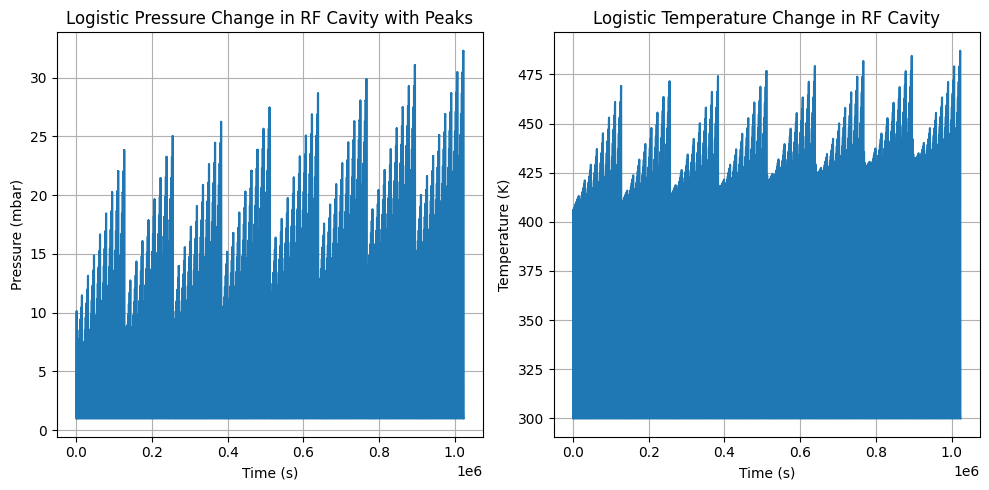

In [ ]:
# Plots
plt.figure(figsize=(10, 5))

# Pressure plot
plt.subplot(1, 2, 1)
plt.plot(df['Time (s)'], df["Pressure (mbar)"])
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mbar)')
plt.title('Logistic Pressure Change in RF Cavity with Peaks')
plt.grid(True)
# Temperature plot
plt.subplot(1, 2, 2)
plt.plot(df['Time (s)'], df['Temperature (K)'])
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Logistic Temperature Change in RF Cavity')
plt.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/MyDrive/Analysis_TARLA/sim_rf_5k.csv'

# Save the DataFrame to a CSV file in the specified path
df.to_csv(file_path, index=False)

In [ ]:
# Number of rows per file
rows_per_file = 2*25 * eval_pts # 2 due excitation and relaxation as individual steps normally, but now (get 5*5*1)*5
count = 1
# Iterate over the DataFrame in chunks
for i in range(0, len(df), rows_per_file):
  df_chunk = df[i:i + rows_per_file]
  df_chunk.to_csv(f'/content/drive/MyDrive/Analysis_TARLA/rf_sim/rf_sim_{count}.txt', index=False,header=False, sep='\t')
  count += 1

# DA-RNN Model

## Preliminaries

### Dependencies

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
!pip install torchviz

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Multiply, Softmax, Concatenate
#from keras.losses import MAPE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.utils import plot_model
from keras import backend as K
import os
from natsort import natsorted


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from torchsummary import summary
from torchviz import make_dot

In [ ]:
#!pip install torchviz

### DA-RNN Model Keras

In [ ]:
def convert_and_process(file_path):
    # Read and process the converted file
    df = pd.read_csv(file_path, delimiter=r'\s+', header=None, names = [out_cols[0],input_cols[0],input_cols[1],input_cols[2],input_cols[3]])
    return df

In [ ]:
def create_dataset(inputs,outputs, n_steps= 60):
  """
  Number of time steps per sequence (60) for an hour
  """
  X, y = [], []
  for i in range(n_steps, len(inputs)):
      end_ix = i - n_steps
      seq_x = inputs.iloc[end_ix:i].values
      seq_y = outputs.iloc[end_ix:i].values
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, tf.float32.max))) * 100

In [ ]:
def wmape_loss(y_true, y_pred, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE) as a loss function.

    Parameters:
    y_true (tensor): Actual values
    y_pred (tensor): Predicted values
    weights (tensor, optional): Weights for the observations. If None, equal weights are assumed.

    Returns:
    tensor: WMAPE value
    """
    if weights is None:
        weights = tf.ones_like(y_true)

    numerator = tf.reduce_sum(weights * tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(weights * y_true)

    wmape_value = numerator / denominator
    return wmape_value

In [ ]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()
rmse_metric = tf.keras.metrics.RootMeanSquaredError()

# Custom Loss Function for MAPE
def custom_mape(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))
    return 100. * K.mean(diff, axis=-1)

# Custom Metric Functions
def custom_mae(y_true, y_pred):
    mae_metric.update_state(y_true, y_pred)
    return mae_metric.result()

def custom_rmse(y_true, y_pred):
    rmse_metric.update_state(y_true, y_pred)
    return rmse_metric.result()

def custom_mse(y_true, y_pred):
    mse_metric.update_state(y_true, y_pred)
    return mse_metric.result()

# Binary Cross-Entropy Loss
def custom_binary_crossentropy(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

# Accuracy
def custom_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)

# Precision
def custom_precision(y_true, y_pred):
    precision_metric.update_state(y_true, y_pred)
    return precision_metric.result()

# Recall
def custom_recall(y_true, y_pred):
    recall_metric.update_state(y_true, y_pred)
    return recall_metric.result()

In [ ]:
def input_attention_mechanism(inputs, prev_hidden_state, prev_cell_state, units):
    # inputs: (batch_size, timesteps, num_features)
    # prev_hidden_state: (batch_size, hidden_size)
    # prev_cell_state: (batch_size, hidden_size)

    # Concatenate the previous hidden state and cell state
    state = tf.concat([prev_hidden_state, prev_cell_state], axis=-1)  # Shape: (batch_size, 2 * hidden_size)

    # Compute attention scores
    W_e = Dense(units)  # Weight matrix for states
    U_e = Dense(units)  # Weight matrix for inputs
    v_e = Dense(1)  # Vector to project to attention scores

    # Apply the layers
    state_proj = W_e(state)  # Shape: (batch_size, units)
    inputs_proj = U_e(inputs)  # Shape: (batch_size, timesteps, units)

    # Add and apply tanh activation
    score = tf.nn.tanh(state_proj[:, tf.newaxis, :] + inputs_proj)  # Shape: (batch_size, timesteps, units)

    # Project to attention scores and apply softmax
    score = v_e(score)  # Shape: (batch_size, timesteps, 1)
    attention_weights = tf.nn.softmax(score, axis=1)  # Shape: (batch_size, timesteps, 1)

    # Compute the context vector as the weighted sum of inputs
    context_vector = attention_weights * inputs  # Shape: (batch_size, timesteps, num_features)
    context_vector = tf.reduce_sum(context_vector, axis=1)  # Shape: (batch_size, num_features)

    return context_vector, attention_weights


In [ ]:
def temporal_attention_mechanism(prev_decoder_hidden_state, prev_decoder_cell_state, encoder_outputs, units):
    # prev_decoder_hidden_state: (batch_size, hidden_size)
    # prev_decoder_cell_state: (batch_size, hidden_size)
    # encoder_outputs: (batch_size, timesteps, hidden_size)

    # Concatenate the previous decoder hidden state and cell state
    state = tf.concat([prev_decoder_hidden_state, prev_decoder_cell_state], axis=-1)  # Shape: (batch_size, 2 * hidden_size)

    # Compute attention scores
    W_d = Dense(units)  # Weight matrix for states
    U_d = Dense(units)  # Weight matrix for encoder outputs
    v_d = Dense(1)  # Vector to project to attention scores

    # Apply the layers
    state_proj = W_d(state)  # Shape: (batch_size, units)
    encoder_proj = U_d(encoder_outputs)  # Shape: (batch_size, timesteps, units)

    # Add and apply tanh activation
    score = tf.nn.tanh(state_proj[:, tf.newaxis, :] + encoder_proj)  # Shape: (batch_size, timesteps, units)

    # Project to attention scores and apply softmax
    score = v_d(score)  # Shape: (batch_size, timesteps, 1)
    attention_weights = tf.nn.softmax(score, axis=1)  # Shape: (batch_size, timesteps, 1)

    # Compute the context vector as the weighted sum of encoder outputs
    context_vector = attention_weights * encoder_outputs  # Shape: (batch_size, timesteps, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1)  # Shape: (batch_size, hidden_size)

    return context_vector, attention_weights


In [ ]:
def da_rnn(input_shape, hidden_size, units, output_size):
    inputs = Input(shape=input_shape)  # Shape: (timesteps, num_features)

    # Initial states for LSTM
    initial_hidden_state = tf.zeros((tf.shape(inputs)[0], hidden_size))
    initial_cell_state = tf.zeros((tf.shape(inputs)[0], hidden_size))

    # Initialize states
    encoder_hidden_state = initial_hidden_state
    encoder_cell_state = initial_cell_state
    decoder_hidden_state = initial_hidden_state
    decoder_cell_state = initial_cell_state

    # Loop through timesteps
    for t in range(input_shape[0]):
        # Input attention
        context_vector, attention_weights = input_attention_mechanism(
            inputs, encoder_hidden_state, encoder_cell_state, units)

        # Encoder LSTM
        encoder_output, encoder_hidden_state, encoder_cell_state = LSTM(hidden_size, return_state=True)(
            tf.expand_dims(context_vector, axis=1), initial_state=[encoder_hidden_state, encoder_cell_state])

        # Compute temporal attention
        temporal_context_vector, temporal_attention_weights = temporal_attention_mechanism(
            decoder_hidden_state, decoder_cell_state, encoder_hidden_state, units)

        # Decoder LSTM
        decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
        decoder_output, decoder_hidden_state, decoder_cell_state = decoder_lstm(
            tf.expand_dims(temporal_context_vector, axis=1), initial_state=[decoder_hidden_state, decoder_cell_state])



    # Output layer
    regression_output = Dense(output_size, activation='sigmoid')(decoder_hidden_state)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=regression_output)

    # Compile the model
    model.compile(optimizer='adam',loss= custom_mape,metrics=[custom_mae, custom_rmse, custom_mse])


    return model

### DA-RNN PyTorch Implementation

In [ ]:
def convert_and_process(file_path):
    # Read and process the converted file
    df = pd.read_csv(file_path, delimiter=r'\s+', header=None, names = [out_cols[0],input_cols[0],input_cols[1],input_cols[2],input_cols[3]])
    return df

In [ ]:
def create_dataset(inputs,outputs, n_steps= 60):
  """
  Number of time steps per sequence (60) for an hour
  """
  X, y = [], []
  for i in range(n_steps, len(inputs)):
      end_ix = i - n_steps
      seq_x = inputs.iloc[end_ix:i].values
      seq_y = outputs.iloc[end_ix:i].values
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_true, y_pred):
        epsilon = 1e-8  # Small constant to avoid division by zero
        loss = torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon)))
        return loss

class InputAttentionMechanism(nn.Module):
    def __init__(self, num_features, hidden_size, units):
        super(InputAttentionMechanism, self).__init__()
        self.W_e = nn.Linear(2 * hidden_size, units)
        self.U_e = nn.Linear(num_features, units)
        self.v_e = nn.Linear(units, 1)

    def forward(self, inputs, prev_hidden_state, prev_cell_state):
        # Concatenate the previous hidden state and cell state
        state = torch.cat((prev_hidden_state, prev_cell_state), dim=-1)  # Shape: (batch_size, 2 * hidden_size)

        # Compute attention scores
        state_proj = self.W_e(state)  # Shape: (batch_size, units)
        inputs_proj = self.U_e(inputs)  # Shape: (batch_size, timesteps, units)

        # Add and apply tanh activation
        score = torch.tanh(state_proj.unsqueeze(1) + inputs_proj)  # Shape: (batch_size, timesteps, units)

        # Project to attention scores and apply softmax
        score = self.v_e(score)  # Shape: (batch_size, timesteps, 1)
        attention_weights = F.softmax(score, dim=1)  # Shape: (batch_size, timesteps, 1)

        # Compute the context vector as the weighted sum of inputs
        context_vector = attention_weights * inputs  # Shape: (batch_size, timesteps, num_features)
        context_vector = context_vector.sum(dim=1)  # Shape: (batch_size, num_features)

        return context_vector, attention_weights


class TemporalAttentionMechanism(nn.Module):
    def __init__(self, hidden_size, units):
        super(TemporalAttentionMechanism, self).__init__()
        self.W_d = nn.Linear(2 * hidden_size, units)
        self.U_d = nn.Linear(hidden_size, units)
        self.v_d = nn.Linear(units, 1)

    def forward(self, prev_decoder_hidden_state, prev_decoder_cell_state, encoder_outputs):
        # Concatenate the previous decoder hidden state and cell state
        state = torch.cat((prev_decoder_hidden_state, prev_decoder_cell_state), dim=-1)  # Shape: (batch_size, 2 * hidden_size)

        # Compute attention scores
        state_proj = self.W_d(state)  # Shape: (batch_size, units)
        encoder_proj = self.U_d(encoder_outputs)  # Shape: (batch_size, timesteps, units)

        # Add and apply tanh activation
        score = torch.tanh(state_proj.unsqueeze(1) + encoder_proj)  # Shape: (batch_size, timesteps, units)

        # Project to attention scores and apply softmax
        score = self.v_d(score)  # Shape: (batch_size, timesteps, 1)
        attention_weights = F.softmax(score, dim=1)  # Shape: (batch_size, timesteps, 1)

        # Compute the context vector as the weighted sum of encoder outputs
        context_vector = attention_weights * encoder_outputs  # Shape: (batch_size, timesteps, hidden_size)
        context_vector = context_vector.sum(dim=1)  # Shape: (batch_size, hidden_size)

        return context_vector, attention_weights


class DARNN(nn.Module):
    def __init__(self, input_shape, hidden_size, units, output_size):
        super(DARNN, self).__init__()
        self.hidden_size = hidden_size
        self.units = units
        self.num_features = input_shape[1]

        self.input_attention = InputAttentionMechanism(self.num_features, hidden_size, units)
        self.temporal_attention = TemporalAttentionMechanism(hidden_size, units)

        self.encoder_lstm = nn.LSTM(self.num_features, hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        batch_size, timesteps, _ = inputs.size()

        # Initial states for LSTM
        h_0 = torch.zeros(1, batch_size, self.hidden_size).to(inputs.device)
        c_0 = torch.zeros(1, batch_size, self.hidden_size).to(inputs.device)

        # Initialize states
        encoder_hidden_state = h_0.squeeze(0)
        encoder_cell_state = c_0.squeeze(0)
        decoder_hidden_state = h_0.squeeze(0)
        decoder_cell_state = c_0.squeeze(0)

        # Loop through timesteps
        for t in range(timesteps):
            # Input attention
            context_vector, _ = self.input_attention(inputs, encoder_hidden_state, encoder_cell_state)
            context_vector = context_vector.unsqueeze(1)  # Shape: (batch_size, 1, num_features)

            # Encoder LSTM
            _, (encoder_hidden_state, encoder_cell_state) = self.encoder_lstm(context_vector, (encoder_hidden_state.unsqueeze(0), encoder_cell_state.unsqueeze(0)))
            encoder_hidden_state = encoder_hidden_state.squeeze(0)
            encoder_cell_state = encoder_cell_state.squeeze(0)

            # Compute temporal attention
            temporal_context_vector, _ = self.temporal_attention(decoder_hidden_state, decoder_cell_state, encoder_hidden_state.unsqueeze(1))
            temporal_context_vector = temporal_context_vector.unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)

            # Decoder LSTM
            _, (decoder_hidden_state, decoder_cell_state) = self.decoder_lstm(temporal_context_vector, (decoder_hidden_state.unsqueeze(0), decoder_cell_state.unsqueeze(0)))
            decoder_hidden_state = decoder_hidden_state.squeeze(0)
            decoder_cell_state = decoder_cell_state.squeeze(0)

        # Output layer
        regression_output = torch.sigmoid(self.output_layer(decoder_hidden_state))

        return regression_output

### Batch Pre-processing (Only to be used if new files are created.)

For now time independent relaxation and excitation used. (Will be adapted to time dependent.). There should be extra Cavity Injected Watt other than voltage, which is the RF Power or the actual voltage applied.

In [ ]:
rf_sim = df.copy()

In [ ]:
input_cols = ['Temperature (K)', 'Pulse Width (s)', 'Pulse Period (s)', 'Voltage (V)']
out_cols = ['Pressure (mbar)']

In [ ]:
for i in range(len(input_cols)):
  rf_sim[input_cols[i]] = MinMaxScaler(feature_range=(0,1)).fit_transform(rf_sim[input_cols[i]].values.reshape(-1,1))

In [ ]:
rf_sim[out_cols[0]] = MinMaxScaler(feature_range=(0,1)).fit_transform(rf_sim[out_cols[0]].values.reshape(-1,1))


In [ ]:
# Number of rows per file
rows_per_file = 2 *64 * eval_pts # 2 due excitation and relaxation as individual steps
# 25 is just for experimentation get for each voltage the period and widths.
count = 1
# Iterate over the DataFrame in chunks
for i in range(0, len(rf_sim), rows_per_file):
  df_chunk = rf_sim[i:i + rows_per_file]
  df_chunk.to_csv(f'/content/drive/MyDrive/Analysis_TARLA/rf_sim/rf_sim_normalized/rf_sim_{count}.txt', index=False,header=False, sep='\t')
  count += 1

### Regular Pre-Process

In [ ]:
input_cols = ['Temperature (K)', 'Pulse Width (s)', 'Pulse Period (s)', 'Voltage (V)']
out_cols = ['Pressure (mbar)']

In [ ]:
# List all text files and shuffle them
directory = '/content/drive/MyDrive/Analysis_TARLA/rf_sim/rf_sim_normalized'

## Model Build for Simulated Data

### Model Build Process

In [ ]:
def train_model(model, n_steps, directory, input_cols, out_cols, val_split=0.1, test_split=0.2):
    # Hyperparameters
    num_epochs = 10 # normally either 10 or 20 epoch but for experimentation simplicity say 1 also val_split is 0.2 and test_split is 0.1 but here make them bigger a lot bigger.
    batch_size = 2  # Minimum acceptable batch_size
    learning_rate = 0.001

    # List all text files and shuffle them
    files = [f for f in natsorted(os.listdir(directory)) if f.endswith('.txt')]

    # Splitting files into training, validation, and test
    split_idx = int(len(files) * (1 - (val_split + test_split)))
    split_idx_test = len(files) - int(len(files) * test_split)
    train_files = files[:split_idx]
    val_files = files[split_idx:split_idx_test]
    test_files = files[split_idx_test:]

    # Constructing the test dataset
    test_data = []
    test_y = []
    train_losses = []
    avg_val_losses = []

    for test_file in test_files:
        test_path = os.path.join(directory, test_file)
        data = convert_and_process(test_path)
        X = data[input_cols]
        y = data[out_cols]
        test_X, test_labels = create_dataset(X, y, n_steps)
        test_data.extend(test_X)
        test_y.extend(test_labels)

    test_data = np.array(test_data, dtype=np.float32)
    test_y = np.array(test_y, dtype=np.float32)
    test_y = test_y[:, -1].reshape(-1, 1).astype(np.float32)

    test_data = torch.tensor(test_data)
    test_y = torch.tensor(test_y)

    criterion = MAPELoss()  # or your custom loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)

    # Load data from all files
    for i, file_name in enumerate(train_files):
        # Load data from current file
        file_path = os.path.join(directory, file_name)
        data = convert_and_process(file_path)
        X = data[input_cols]
        y = data[out_cols]
        X, y = create_dataset(X, y, n_steps)
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
        y = y[:, -1].reshape(-1, 1).astype(np.float32)

        # Create tensor datasets
        train_dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Load weights from the previous iteration
        if i > 0:
            model.load_state_dict(torch.load('/content/drive/MyDrive/project/model_weights.pth'))

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(model.device), labels.to(model.device)
                optimizer.zero_grad()
                # Forward Pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)


            print(f'Epoch {epoch + 1}/{num_epochs}, File {i + 1}/{len(train_files)}, Train Loss: {train_loss:.4f}')

        train_losses.append([i+1,train_loss])
        # Save the model weights
        torch.save(model.state_dict(), '/content/drive/MyDrive/project/model_weights.pth')

        # Validation
        total_val_loss = 0
        num_val_files = len(val_files)
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for val_file in val_files:
                val_path = os.path.join(directory, val_file)
                data = convert_and_process(val_path)
                val_X = data[input_cols]
                val_y = data[out_cols]
                val_X, val_y = create_dataset(val_X, val_y, n_steps)

                val_X = np.array(val_X, dtype=np.float32)
                val_y = np.array(val_y, dtype=np.float32)
                val_y = val_y[:, -1].reshape(-1, 1).astype(np.float32)

                val_X = torch.tensor(val_X)
                val_y = torch.tensor(val_y)

                val_X, val_y = val_X.to(model.device), val_y.to(model.device)

                outputs = model(val_X)
                val_loss = criterion(outputs, val_y)
                total_val_loss += val_loss.item()

                print(f'Validation Loss for {val_file}: {val_loss:.4f}')

        average_val_loss = total_val_loss / num_val_files
        avg_val_losses.append([i+1,average_val_loss])
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        # Save the model weights after each file iteration
        torch.save(model.state_dict(), '/content/drive/MyDrive/project/model_weights.pth')
        print("Model weights saved.")

    return model, test_data, test_y, avg_val_losses, train_losses

In [ ]:
def summary(model, input_size):
    def get_parameter_number(module):
        num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        return num_params

    total_params = get_parameter_number(model)
    print(f"Total Trainable Parameters: {total_params}")

    print("=== Model Architecture ===")
    print(model)

# Assuming input_shape is a tuple of (timesteps, num_features)
input_shape = (2, 4)  # Example input shape
hidden_size = 20
units = 10
output_size = 1

# Define your model, n_steps, directory, input_cols, and out_cols
model = DARNN(input_shape, hidden_size, units, output_size)
model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(model.device)

# Print model summary
summary(model, input_shape)

# Visualize the model architecture
x = torch.randn(1, *input_shape).to(model.device)  # Dummy input tensor
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'jpeg'
dot.render("model_architecture")

Total Trainable Parameters: 6563
=== Model Architecture ===
DARNN(
  (input_attention): InputAttentionMechanism(
    (W_e): Linear(in_features=40, out_features=10, bias=True)
    (U_e): Linear(in_features=4, out_features=10, bias=True)
    (v_e): Linear(in_features=10, out_features=1, bias=True)
  )
  (temporal_attention): TemporalAttentionMechanism(
    (W_d): Linear(in_features=40, out_features=10, bias=True)
    (U_d): Linear(in_features=20, out_features=10, bias=True)
    (v_d): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder_lstm): LSTM(4, 20, batch_first=True)
  (decoder_lstm): LSTM(20, 20, batch_first=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)


'model_architecture.jpeg'

### Train

In [ ]:
n_steps = 2
num_features = 4
input_shape = (n_steps, num_features)  # 5 timesteps, 4 features try 2?
hidden_size = 20
units = 10
output_size = 1 # Number of classes

# Define your model, n_steps, directory, input_cols, and out_cols
model = DARNN(input_shape, hidden_size, units, output_size)
model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(model.device)

# Train the model
trained_model, test_data, test_y, avg_val_losses, train_losses = train_model(model, n_steps, directory, input_cols, out_cols)

Epoch 1/10, File 1/5, Train Loss: 0.5229
Epoch 2/10, File 1/5, Train Loss: 0.4502


KeyboardInterrupt: 

### Evaluation

In [ ]:
n_steps = 2


In [ ]:
    # List all text files and shuffle them
    files = [f for f in natsorted(os.listdir(directory)) if f.endswith('.txt')]

    # Splitting files into training, validation, and test
    split_idx = int(len(files) * (1 - (0.1 + 0.2)))
    split_idx_test = len(files) - int(len(files) * 0.2)
    train_files = files[:split_idx]
    val_files = files[split_idx:split_idx_test]
    test_files = files[split_idx_test:]

    # Constructing the test dataset
    test_data = []
    test_y = []
    train_losses = []
    avg_val_losses = []

    for test_file in test_files:
        test_path = os.path.join(directory, test_file)
        data = convert_and_process(test_path)
        X = data[input_cols]
        y = data[out_cols]
        test_X, test_labels = create_dataset(X, y, n_steps)
        test_data.extend(test_X)
        test_y.extend(test_labels)

    test_data = np.array(test_data, dtype=np.float32)
    test_y = np.array(test_y, dtype=np.float32)
    test_y = test_y[:, -1].reshape(-1, 1).astype(np.float32)

    test_data = torch.tensor(test_data)
    test_y = torch.tensor(test_y)


In [ ]:
n_steps = 2
num_features = 4
input_shape = (n_steps, num_features)  # 5 timesteps, 4 features try 2?
hidden_size = 20
units = 10
output_size = 1 # Number of classes

# Define your model, n_steps, directory, input_cols, and out_cols
trained_model = DARNN(input_shape, hidden_size, units, output_size)
trained_model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(trained_model.device)

DARNN(
  (input_attention): InputAttentionMechanism(
    (W_e): Linear(in_features=40, out_features=10, bias=True)
    (U_e): Linear(in_features=4, out_features=10, bias=True)
    (v_e): Linear(in_features=10, out_features=1, bias=True)
  )
  (temporal_attention): TemporalAttentionMechanism(
    (W_d): Linear(in_features=40, out_features=10, bias=True)
    (U_d): Linear(in_features=20, out_features=10, bias=True)
    (v_d): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder_lstm): LSTM(4, 20, batch_first=True)
  (decoder_lstm): LSTM(20, 20, batch_first=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/project/model_weights.pth'))
trained_model.eval()
criterion = MAPELoss()
with torch.no_grad():
  test_outputs = trained_model(test_data)
  test_loss = criterion(test_outputs, test_y)
  print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.4369


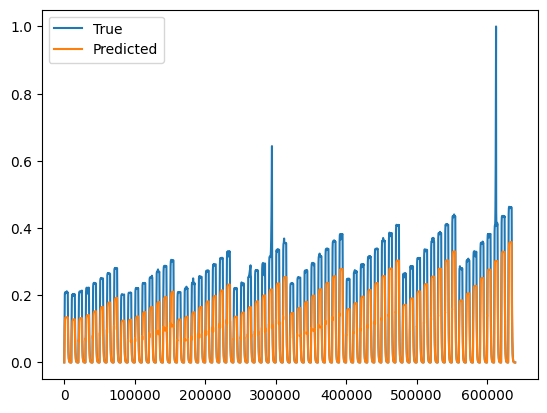

In [ ]:
plt.plot(test_y.cpu().numpy(), label='True')
plt.plot(test_outputs.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [ ]:
train_loss = pd.DataFrame(train_losses)
train_loss.columns = ['File', 'Loss']
avg_val_losses = pd.DataFrame(avg_val_losses)
avg_val_losses.columns = ['File', 'Loss']

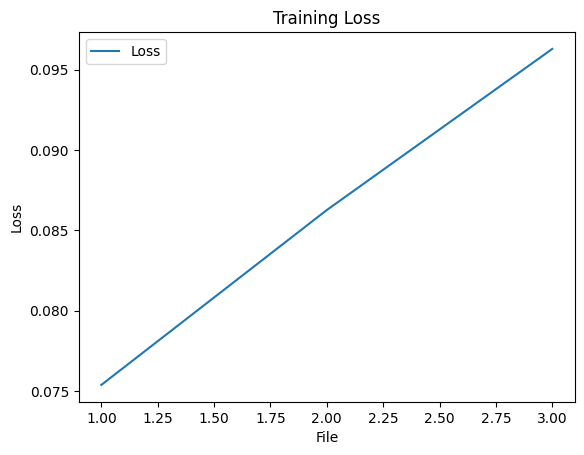

In [ ]:
train_loss.plot(x='File', y='Loss')
plt.title('Training Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.show()

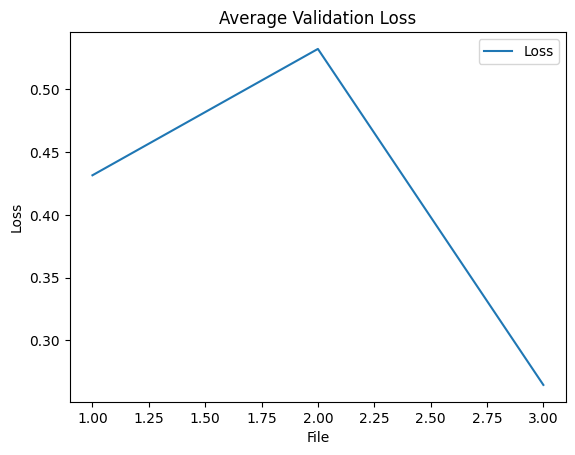

In [ ]:
avg_val_losses.plot(x='File', y='Loss')
plt.title('Average Validation Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.show()

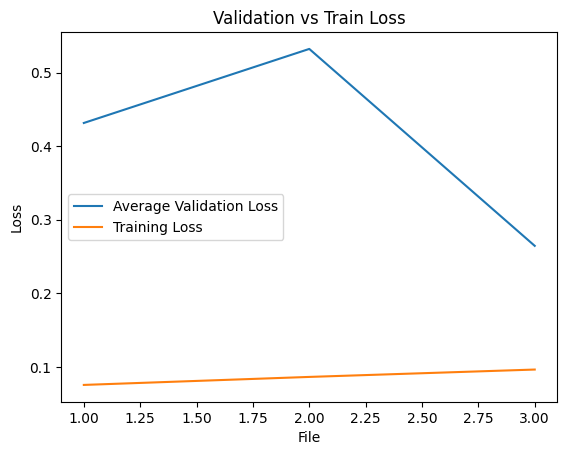

In [ ]:
plt.plot(avg_val_losses['File'],avg_val_losses['Loss'], label='Average Validation Loss')
plt.plot(train_loss['File'],train_loss['Loss'] ,label='Training Loss')
plt.title('Validation vs Train Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_output_np = test_outputs.numpy()
test_y_np = test_y.numpy()

file_path = "results.txt"


header = "Predicted Values\tTrue Values"

combined_data = np.column_stack((test_output_np, test_y_np))


np.savetxt(file_path, combined_data, fmt='%f', delimiter='\t', header=header, comments='')



In [ ]:
plt.plot(test_output_np, label='Predicted')
plt.plot(test_y_np, label='True')
plt.legend()
plt.show()

# DA-RNN PARALLEL MULTI-MODEL(ENSEMBLE LEARNING)

## Preprocess

In [ ]:
input_cols = ['Temperature (K)', 'Pulse Width (s)', 'Pulse Period (s)', 'Voltage (V)']
out_cols = ['Pressure (mbar)']

In [ ]:
# List all text files and shuffle them
directory = '/content/drive/MyDrive/Analysis_TARLA/rf_sim/rf_sim_normalized'

## Training System

In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

In [ ]:
def train_model(model, n_steps, directory, input_cols, out_cols, val_split=0.1, test_split=0.2, names = "darnn"):
    # Hyperparameters
    num_epochs = 10  # Example
    batch_size = 2
    learning_rate = 0.001

    # List all text files and shuffle them
    files = [f for f in natsorted(os.listdir(directory)) if f.endswith('.txt')]

    # Splitting files into training, validation, and test
    split_idx = int(len(files) * (1 - (val_split + test_split)))
    split_idx_test = len(files) - int(len(files) * test_split)
    train_files = files[:split_idx]
    val_files = files[split_idx:split_idx_test]
    test_files = files[split_idx_test:]

    # Initialize containers for training and test data
    train_data = []
    train_y = []
    test_data = []
    test_y = []
    train_losses = []
    avg_val_losses = []

    # Construct the test dataset
    for test_file in test_files:
        test_path = os.path.join(directory, test_file)
        data = convert_and_process(test_path)
        X = data[input_cols]
        y = data[out_cols]
        test_X, test_labels = create_dataset(X, y, n_steps)
        test_data.extend(test_X)
        test_y.extend(test_labels)

    test_data = np.array(test_data, dtype=np.float32)
    test_y = np.array(test_y, dtype=np.float32)
    test_y = test_y[:, -1].reshape(-1, 1).astype(np.float32)

    test_data = torch.tensor(test_data)
    test_y = torch.tensor(test_y)

    criterion = MAPELoss()  # Or your custom loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Load and process training data
    for i, file_name in enumerate(train_files):
        # Load data from current file
        file_path = os.path.join(directory, file_name)
        data = convert_and_process(file_path)
        X = data[input_cols]
        y = data[out_cols]
        X, y = create_dataset(X, y, n_steps)
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
        y = y[:, -1].reshape(-1, 1).astype(np.float32)

        train_data.extend(X)
        train_y.extend(y)

        # Create tensor datasets
        train_dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Load weights from the previous iteration
        if i > 0:
            model.load_state_dict(torch.load(f'/content/drive/MyDrive/project/model_weights_{names}.pth', weights_only = True))

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(model.device), labels.to(model.device)
                optimizer.zero_grad()
                # Forward Pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)
            print(f'Epoch {epoch + 1}/{num_epochs}, File {i + 1}/{len(train_files)}, Train Loss: {train_loss:.4f}')

        train_losses.append([i + 1, train_loss])
        # Save the model weights
        torch.save(model.state_dict(), f'/content/drive/MyDrive/project/model_weights_{names}.pth')

        # Validation
        total_val_loss = 0
        num_val_files = len(val_files)
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for val_file in val_files:
                val_path = os.path.join(directory, val_file)
                data = convert_and_process(val_path)
                val_X = data[input_cols]
                val_y = data[out_cols]
                val_X, val_y = create_dataset(val_X, val_y, n_steps)

                val_X = np.array(val_X, dtype=np.float32)
                val_y = np.array(val_y, dtype=np.float32)
                val_y = val_y[:, -1].reshape(-1, 1).astype(np.float32)

                val_X = torch.tensor(val_X)
                val_y = torch.tensor(val_y)

                val_X, val_y = val_X.to(model.device), val_y.to(model.device)

                outputs = model(val_X)
                val_loss = criterion(outputs, val_y)
                total_val_loss += val_loss.item()

                print(f'Validation Loss for {val_file}: {val_loss:.4f}')

        average_val_loss = total_val_loss / num_val_files
        avg_val_losses.append([i + 1, average_val_loss])
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        # Save the model weights after each file iteration
        torch.save(model.state_dict(), f'/content/drive/MyDrive/project/model_weights_{names}.pth')
        print("Model weights saved.")

    train_data = np.array(train_data, dtype=np.float32)
    train_y = np.array(train_y, dtype=np.float32)

    return model, train_data, test_data, test_y, avg_val_losses, train_losses

## CNN-LSTM

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_shape, cnn_filters, lstm_hidden_size, dense_units, output_size):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_shape[1], out_channels=cnn_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(cnn_filters, lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, dense_units)
        self.output_layer = nn.Linear(dense_units, output_size)

    def forward(self, x):
        # Permute for CNN: [batch_size, features, timesteps]
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        # Permute back for LSTM: [batch_size, timesteps, cnn_filters]
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        dense_out = self.fc(lstm_out)
        output = self.output_layer(dense_out)
        return torch.sigmoid(output)


## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_isolation_forest(train_data, n_estimators=100, contamination=0.01):
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(train_data.shape[0], -1))  # Flatten for training
    iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
    iso_forest.fit(train_data_scaled)
    return iso_forest, scaler

def predict_isolation_forest(iso_forest, scaler, test_data):
    test_data_scaled = scaler.transform(test_data.reshape(test_data.shape[0], -1))  # Flatten for prediction
    scores = iso_forest.decision_function(test_data_scaled)  # Higher = less anomalous
    return scores



## Ensemble

In [ ]:
def normalize_predictions(*model_predictions):
    scaler = MinMaxScaler()
    normalized_preds = [scaler.fit_transform(pred.reshape(-1, 1)) for pred in model_predictions]
    return normalized_preds

In [ ]:
def ensemble_predict(da_rnn_preds, cnn_lstm_preds, iso_forest_scores, weights=[0.4, 0.4, 0.2]):
    da_rnn_norm, cnn_lstm_norm, iso_forest_norm = normalize_predictions(da_rnn_preds, cnn_lstm_preds, iso_forest_scores)
    ensemble_preds = (weights[0] * da_rnn_norm + weights[1] * cnn_lstm_norm + weights[2] * iso_forest_norm).flatten()
    return ensemble_preds


In [ ]:
from concurrent.futures import ThreadPoolExecutor

def train_parallel_models(da_rnn_model, cnn_lstm_model, iso_forest_params, train_data, test_data, n_steps, directory, input_cols, out_cols):
    # Train DA-RNN and CNN-LSTM in parallel
    with ThreadPoolExecutor() as executor:
        da_rnn_future = executor.submit(train_model, da_rnn_model, n_steps, directory, input_cols, out_cols)
        cnn_lstm_future = executor.submit(train_model, cnn_lstm_model, n_steps, directory, input_cols, out_cols)

        # Train Isolation Forest
        iso_forest, scaler = train_isolation_forest(train_data, **iso_forest_params)

        # Collect trained models
        da_rnn_trained, _, _, _, _ = da_rnn_future.result()
        cnn_lstm_trained, _, _, _, _ = cnn_lstm_future.result()

    return da_rnn_trained, cnn_lstm_trained, iso_forest, scaler


In [ ]:
def make_predictions(da_rnn_model, cnn_lstm_model, iso_forest, scaler, test_data):
    # Predict with DA-RNN
    da_rnn_model.eval()
    cnn_lstm_model.eval()
    with torch.no_grad():
        da_rnn_preds = da_rnn_model(test_data).cpu().numpy()
        cnn_lstm_preds = cnn_lstm_model(test_data).cpu().numpy()

    # Predict with Isolation Forest
    iso_forest_scores = predict_isolation_forest(iso_forest, scaler, test_data.numpy())

    return da_rnn_preds, cnn_lstm_preds, iso_forest_scores


## Meta-Model

In [ ]:
class MetaModel(nn.Module):
    def __init__(self, input_dim=4):  # Adjust input_dim to match meta_inputs
        super(MetaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)  # Match input_dim (the 4 models)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)  # Output size is 1 (final prediction)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x


In [ ]:
def prepare_meta_data(da_rnn_preds, cnn_lstm_preds, iso_forest_scores, ground_truth):
    """
    Prepare input data for the meta-model.
    :param da_rnn_preds: Predictions from DA-RNN.
    :param cnn_lstm_preds: Predictions from CNN-LSTM.
    :param iso_forest_scores: Anomaly scores from Isolation Forest.
    :param ground_truth: Ground truth labels for the dataset.
    """

    # Combine inputs
    meta_inputs = np.hstack((da_rnn_preds, cnn_lstm_preds, iso_forest_scores))
    meta_targets = ground_truth.reshape(-1, 1)  # Ensure targets are the correct shape
    return torch.tensor(meta_inputs, dtype=torch.float32), torch.tensor(meta_targets, dtype=torch.float32)


In [ ]:
def train_meta_model(meta_model, meta_inputs, meta_targets, num_epochs=20, batch_size=16, learning_rate=0.001):
    dataset = TensorDataset(meta_inputs, meta_targets)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=learning_rate)

    meta_model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = meta_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(data_loader):.4f}")

    return meta_model


In [ ]:
def predict_with_meta_model(meta_model, da_rnn_preds, cnn_lstm_preds, iso_forest_scores):
    """
    Use the trained meta-model for final predictions.
    """
    meta_inputs = np.hstack((da_rnn_preds, cnn_lstm_preds, iso_forest_scores))
    meta_inputs = torch.tensor(meta_inputs, dtype=torch.float32)

    meta_model.eval()
    with torch.no_grad():
        final_preds = meta_model(meta_inputs).cpu().numpy()

    return final_preds


## Train

### parameters

In [ ]:
# Define the input shape and hyperparameters DA-RNN hyperparameters
input_shape = (2, 4)  # Example input shape (timesteps, num_features)
hidden_size = 20
units = 10
output_size = 1

# CNN-LSTM hyperparameters
cnn_filters = 16
lstm_hidden_size = 20
dense_units = 10
n_steps = 2

# Define Isolation Forest parameters
iso_forest_params = {
    'n_estimators': 100,          # Number of trees in the forest
    'contamination': 0.01,        # Proportion of anomalies in the dataset (adjust based on your data)
}

In [ ]:
# DA-RNN Model
da_rnn_model = DARNN(input_shape, hidden_size, units, output_size)
da_rnn_model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
da_rnn_model.to(da_rnn_model.device)


DARNN(
  (input_attention): InputAttentionMechanism(
    (W_e): Linear(in_features=40, out_features=10, bias=True)
    (U_e): Linear(in_features=4, out_features=10, bias=True)
    (v_e): Linear(in_features=10, out_features=1, bias=True)
  )
  (temporal_attention): TemporalAttentionMechanism(
    (W_d): Linear(in_features=40, out_features=10, bias=True)
    (U_d): Linear(in_features=20, out_features=10, bias=True)
    (v_d): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder_lstm): LSTM(4, 20, batch_first=True)
  (decoder_lstm): LSTM(20, 20, batch_first=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
# CNN-LSTM Model
cnn_lstm_model = CNNLSTM(input_shape, cnn_filters=16, lstm_hidden_size=20, dense_units=10, output_size=1)
cnn_lstm_model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_lstm_model.to(cnn_lstm_model.device)

CNNLSTM(
  (cnn): Sequential(
    (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(16, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

### train

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Define a function for parallel training
def train_single_model(model, n_steps, directory, input_cols, out_cols, name):
    print(f"Starting training for {name}")
    return train_model(model, n_steps, directory, input_cols, out_cols, names=name)

#train DA-RNN and CNN-LSTM concurrently
with ThreadPoolExecutor(max_workers=2) as executor:
    # Submit tasks for training
    da_rnn_future = executor.submit(train_single_model, da_rnn_model, n_steps, directory, input_cols, out_cols, "darnn")
    cnn_lstm_future = executor.submit(train_single_model, cnn_lstm_model, n_steps, directory, input_cols, out_cols, "cnnlstm")

    # Wait for results
    da_rnn_trained, train_data, test_data, test_y, _, _ = da_rnn_future.result()
    cnn_lstm_trained, _, _, _, _, _ = cnn_lstm_future.result()

print("DA-RNN and CNN-LSTM training complete.")

Starting training for darnn
Starting training for cnnlstm
Epoch 1/10, File 1/5, Train Loss: 0.5029
Epoch 2/10, File 1/5, Train Loss: 0.4387
Epoch 1/10, File 1/5, Train Loss: 0.5259
Epoch 3/10, File 1/5, Train Loss: 0.4254
Epoch 4/10, File 1/5, Train Loss: 0.4075
Epoch 5/10, File 1/5, Train Loss: 0.3707
Epoch 2/10, File 1/5, Train Loss: 0.4486
Epoch 6/10, File 1/5, Train Loss: 0.3351
Epoch 7/10, File 1/5, Train Loss: 0.3158
Epoch 3/10, File 1/5, Train Loss: 0.4124
Epoch 8/10, File 1/5, Train Loss: 0.3018
Epoch 9/10, File 1/5, Train Loss: 0.2891
Epoch 10/10, File 1/5, Train Loss: 0.2785
Validation Loss for rf_sim_6.txt: 0.5110
Validation Loss for rf_sim_7.txt: 0.5794
Average Validation Loss: 0.5452
Model weights saved.
Epoch 4/10, File 1/5, Train Loss: 0.3784
Epoch 1/10, File 2/5, Train Loss: 0.2556
Epoch 2/10, File 2/5, Train Loss: 0.2522
Epoch 3/10, File 2/5, Train Loss: 0.2404
Epoch 5/10, File 1/5, Train Loss: 0.3589
Epoch 4/10, File 2/5, Train Loss: 0.2349
Epoch 5/10, File 2/5, Train

In [ ]:
# Train Isolation Forest on flattened train data
iso_train_data = train_data.reshape(train_data.shape[0], -1)  # Flatten for Isolation Forest
iso_forest, scaler = train_isolation_forest(iso_train_data, **iso_forest_params)


# Flatten train/test data for Isolation Forest
iso_test_data = test_data.numpy().reshape(test_data.shape[0], -1)  # Flatten for testing

iso_forest_scores = predict_isolation_forest(iso_forest, scaler, iso_test_data)

# Ensure all inputs have the same number of dimensions
if iso_forest_scores.ndim == 1:
    iso_forest_scores = iso_forest_scores.reshape(-1, 1)  # Reshape to (N, 1)

# Predict using DA-RNN and CNN-LSTM
da_rnn_model.eval()
cnn_lstm_model.eval()
with torch.no_grad():
    da_rnn_preds = da_rnn_trained(test_data).cpu().numpy()
    cnn_lstm_preds = cnn_lstm_trained(test_data).cpu().numpy()

# Prepare data for meta-model
meta_inputs, meta_targets = prepare_meta_data(da_rnn_preds, cnn_lstm_preds, iso_forest_scores, test_y.numpy())

# Train the meta-model
meta_model = MetaModel()
meta_model = train_meta_model(meta_model, meta_inputs, meta_targets)

# Make final predictions
final_predictions = predict_with_meta_model(meta_model, da_rnn_preds, cnn_lstm_preds, iso_forest_scores)

print("Final Ensemble Predictions from Meta-Model:", final_predictions)


Epoch 1/20, Loss: 0.5614
Epoch 2/20, Loss: 0.3930
Epoch 3/20, Loss: 0.3747
Epoch 4/20, Loss: 0.3719
Epoch 5/20, Loss: 0.3703
Epoch 6/20, Loss: 0.3693
Epoch 7/20, Loss: 0.3686
Epoch 8/20, Loss: 0.3679
Epoch 9/20, Loss: 0.3675
Epoch 10/20, Loss: 0.3671
Epoch 11/20, Loss: 0.3667
Epoch 12/20, Loss: 0.3664
Epoch 13/20, Loss: 0.3661
Epoch 14/20, Loss: 0.3659
Epoch 15/20, Loss: 0.3657
Epoch 16/20, Loss: 0.3656
Epoch 17/20, Loss: 0.3655
Epoch 18/20, Loss: 0.3653
Epoch 19/20, Loss: 0.3652
Epoch 20/20, Loss: 0.3650
Final Ensemble Predictions from Meta-Model: [[0.0254197 ]
 [0.11370437]
 [0.17881165]
 ...
 [0.00751159]
 [0.00751122]
 [0.00751093]]


## Predictions

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(meta_targets, da_rnn_preds, cnn_lstm_preds, iso_forest_scores, final_predictions):
    """
    Plot predictions from DA-RNN, CNN-LSTM, Isolation Forest, and the Meta-Model.
    :param meta_targets: Ground truth values.
    :param da_rnn_preds: Predictions from DA-RNN.
    :param cnn_lstm_preds: Predictions from CNN-LSTM.
    :param iso_forest_scores: Anomaly scores from Isolation Forest.
    :param final_predictions: Final predictions from the Meta-Model.
    """
    plt.figure(figsize=(14, 8))

    # Plot Ground Truth
    plt.plot(meta_targets, label='Ground Truth', linestyle='--', color='black')

    # Plot DA-RNN Predictions
    plt.plot(da_rnn_preds, label='DA-RNN Predictions', alpha=0.7)

    # Plot CNN-LSTM Predictions
    plt.plot(cnn_lstm_preds, label='CNN-LSTM Predictions', alpha=0.7)

    # Plot Isolation Forest Scores
    plt.plot(iso_forest_scores, label='Isolation Forest Scores', alpha=0.7)

    # Plot Final Meta-Model Predictions
    plt.plot(final_predictions, label='Meta-Model Predictions', linewidth=2, color='red')

    # Add title and legend
    plt.title('Meta-Model Predictions vs Individual Models')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction / Score')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


Final Ensemble Predictions from Meta-Model: [[0.0254197 ]
 [0.11370437]
 [0.17881165]
 ...
 [0.00751159]
 [0.00751122]
 [0.00751093]]


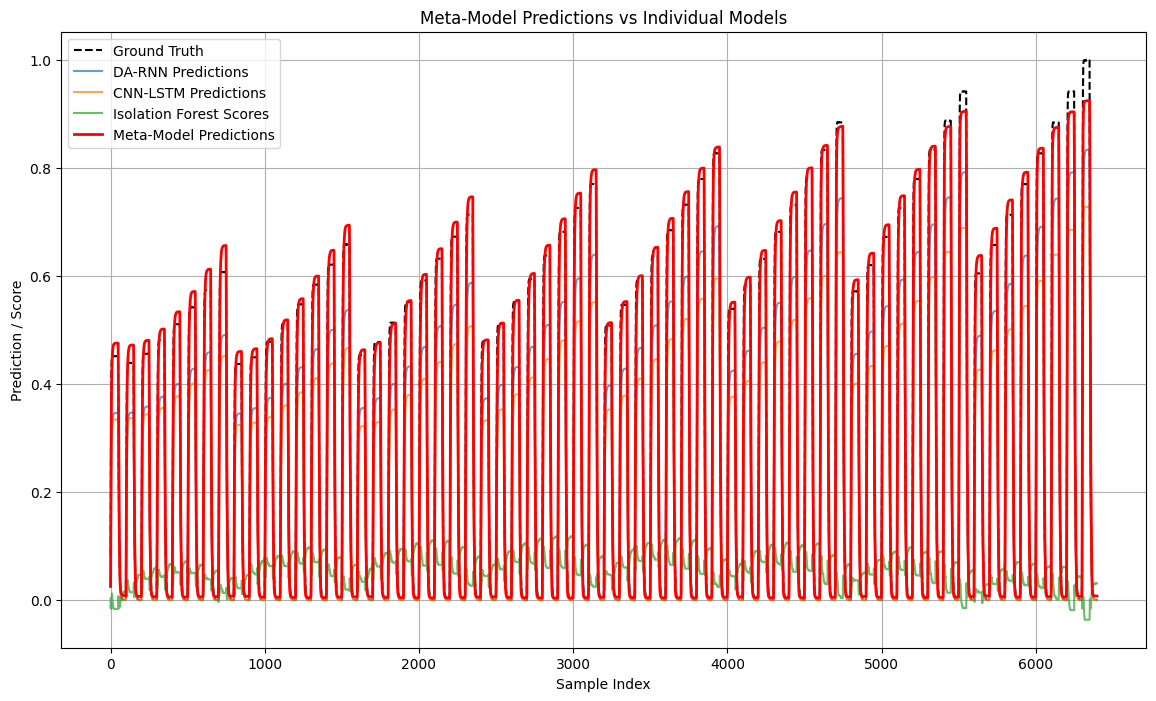

In [ ]:
# After making predictions
print("Final Ensemble Predictions from Meta-Model:", final_predictions)

# Plot results
plot_predictions(meta_targets.numpy(), da_rnn_preds.flatten(), cnn_lstm_preds.flatten(), iso_forest_scores.flatten(), final_predictions.flatten())


# Deployment

## Simulation Test

In [ ]:
def detect_time_series_anomalies(meta_predictions, baseline=0.2, change_threshold=0.1):
    """
    Detect anomalies in a time series based on changes relative to the prior value.
    :param meta_predictions: Array of meta-model predictions.
    :param baseline: Minimum value to consider for anomaly detection.
    :param change_threshold: Minimum positive change to flag as an anomaly.
    :return: Array of anomaly flags (1 for anomaly, 0 for normal).
    """
    anomalies = np.zeros_like(meta_predictions, dtype=int)

    for i in range(1, len(meta_predictions)):
        # Check if the current value is above the baseline
        if meta_predictions[i] > baseline:
            # Check if the change from the prior value exceeds the threshold in the positive direction
            if (meta_predictions[i] - meta_predictions[i - 1]) > change_threshold:
                anomalies[i] = 1  # Mark as anomaly

    return anomalies


In [ ]:
def plot_time_series_anomalies(meta_predictions, anomalies, meta_targets):
    """
    Plot meta-model predictions with detected time-series anomalies.
    :param meta_predictions: Meta-model predictions.
    :param anomalies: Detected anomalies (1 for anomaly, 0 for normal).
    :param meta_targets: Ground truth values.
    """
    plt.figure(figsize=(14, 8))

    # Plot meta-model predictions
    plt.plot(meta_predictions, label='Meta-Model Predictions', color='red', alpha=0.7)

    # Overlay ground truth
    plt.plot(meta_targets, label='Ground Truth', linestyle='--', color='black')

    # Highlight detected anomalies
    plt.scatter(
        np.arange(len(meta_predictions))[anomalies == 1],
        meta_predictions[anomalies == 1],
        color='blue', label='Detected Anomalies', marker='o'
    )

    # Add legend and labels
    plt.title('Anomalies Detected in Meta-Model Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction Value')
    plt.legend()
    plt.grid(True)

    plt.show()


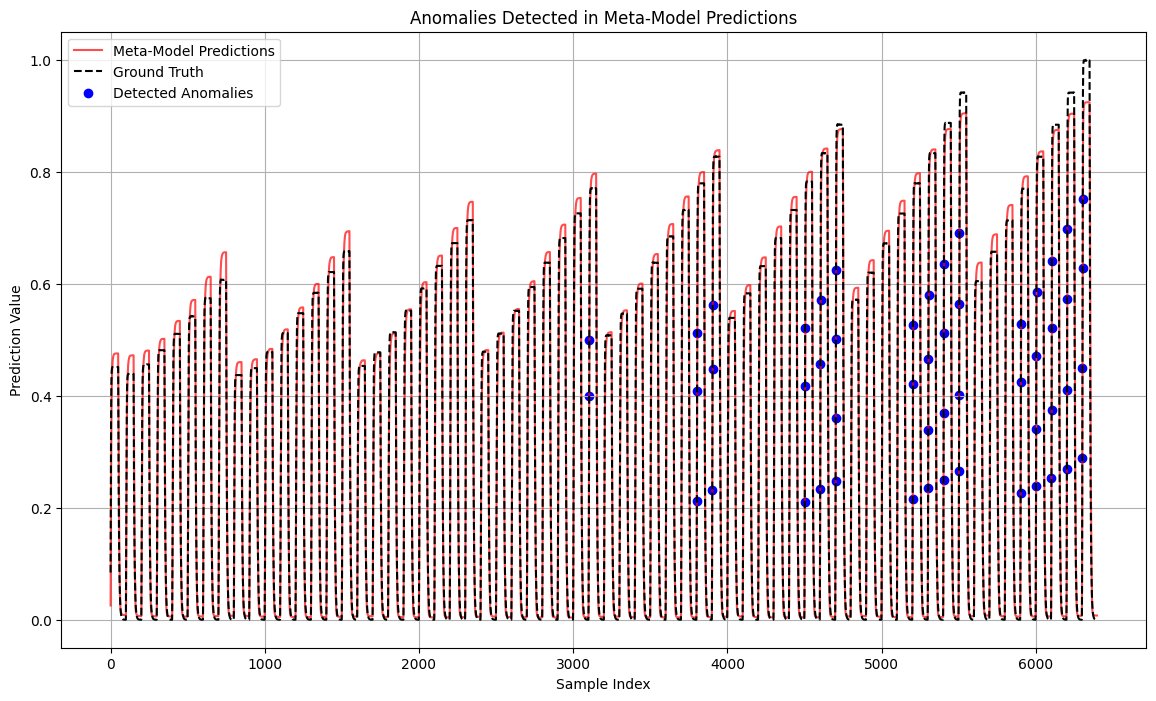

In [ ]:
# Detect anomalies
baseline = 0.2  # Minimum value to consider
change_threshold = 0.1  # Minimum change from the prior value
anomalies = detect_time_series_anomalies(final_predictions.flatten(), baseline, change_threshold)

# Plot the results
plot_time_series_anomalies(final_predictions.flatten(), anomalies, meta_targets.flatten())


In [ ]:
def real_time_anomaly_detection(current_value, previous_value, baseline=0.2, change_threshold=0.1):
    """
    Real-time anomaly detection based on the current and previous values.
    :param current_value: Current prediction value.
    :param previous_value: Previous prediction value.
    :param baseline: Minimum value to consider for anomaly detection.
    :param change_threshold: Minimum change from the prior value to flag as an anomaly.
    :return: Boolean indicating whether an anomaly is detected.
    """
    # Check if the current value is above the baseline and the change exceeds the threshold
    if current_value > baseline and (current_value - previous_value) > change_threshold:
        return True  # Anomaly detected
    return False  # Normal


In [ ]:
# Example real-time data stream
meta_predictions = final_predictions.flatten()  # Example predictions array
baseline = 0.2
change_threshold = 0.1

# Iterate through predictions (simulate real-time stream)
for i in range(1, len(meta_predictions)):
    current_value = meta_predictions[i]
    previous_value = meta_predictions[i - 1]

    # Check for anomaly
    if real_time_anomaly_detection(current_value, previous_value, baseline, change_threshold):
        print(f"Anomaly Detected at index {i} with value {current_value}")
        break  # Exit after detecting one anomaly
    else:
        print(f"Normal at index {i} with value {current_value}")


Normal at index 1 with value 0.1137043684720993
Normal at index 2 with value 0.17881165444850922
Normal at index 3 with value 0.25465962290763855
Normal at index 4 with value 0.3101958632469177
Normal at index 5 with value 0.35439956188201904
Normal at index 6 with value 0.38699761033058167
Normal at index 7 with value 0.4092087745666504
Normal at index 8 with value 0.4238164722919464
Normal at index 9 with value 0.4348601996898651
Normal at index 10 with value 0.4437694549560547
Normal at index 11 with value 0.4510669708251953
Normal at index 12 with value 0.45614030957221985
Normal at index 13 with value 0.46088334918022156
Normal at index 14 with value 0.4640941619873047
Normal at index 15 with value 0.4661528468132019
Normal at index 16 with value 0.467756062746048
Normal at index 17 with value 0.47030577063560486
Normal at index 18 with value 0.471376895904541
Normal at index 19 with value 0.47215643525123596
Normal at index 20 with value 0.4727751314640045
Normal at index 21 with

## Real_Data_Code

In [ ]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def standardize(data):
    """
    Standardize the data (Z-score normalization).
    Returns the standardized data, mean, and std deviation.
    """
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / (std + 1e-8)  # Add small epsilon to avoid division by zero
    return standardized_data, mean, std

def inverse_standardize(data, mean, std):
    """
    Revert standardization back to the original scale.
    """
    return data * std + mean


def scaled_log_scale(data, scale_factor=1e9):
    """
    Applies a scaled log transformation to data.
    :param data: Array of input data.
    :param scale_factor: Scaling factor to bring small values into a larger range.
    :return: Transformed data.
    """
    return np.log1p(data * scale_factor)

def inverse_scaled_log_scale(data, scale_factor=1e9):
    """
    Inverts the scaled log transformation.
    :param data: Transformed data.
    :param scale_factor: Scaling factor used in the forward transformation.
    :return: Original data.
    """
    return np.expm1(data) / scale_factor

def preprocess_data(data_path, input_cols, out_cols, val_split=0.1, test_split=0.2, n_steps=60, scale_factor=1e9, pressure_threshold=7.0e-9):
    """
    Preprocess the dataset with filtering and scaled log transformation for small values.
    """
    # Load the entire dataset
    data = pd.read_csv(data_path)

    # Filter rows based on the pressure threshold
    filtered_data = data.iloc[:data.loc[data[out_cols[0]] > pressure_threshold].index[-1] + 1].copy()

    # Standardize input features
    scaling_params = {}
    for col in input_cols:
        standardized_col, mean, std = standardize(filtered_data[col].values)
        filtered_data.loc[:, col] = standardized_col  # Use .loc to avoid SettingWithCopyWarning
        scaling_params[col] = {'mean': mean, 'std': std}

    # Apply scaled log transformation to the output column
    transformed_output = scaled_log_scale(filtered_data[out_cols[0]].values, scale_factor=scale_factor)
    filtered_data.loc[:, out_cols[0]] = transformed_output  # Use .loc to avoid SettingWithCopyWarning

    # Split the dataset
    train_data, val_test_data = train_test_split(filtered_data, test_size=(val_split + test_split), random_state=42)
    val_data, test_data = train_test_split(val_test_data, test_size=(test_split / (val_split + test_split)), random_state=42)

    def prepare_data(data):
        X = data[input_cols].values
        y = data[out_cols].values
        return create_dataset(pd.DataFrame(X), pd.DataFrame(y), n_steps)

    train_X, train_y = prepare_data(train_data)
    val_X, val_y = prepare_data(val_data)
    test_X, test_y = prepare_data(test_data)

    # Save inverse scaling functions
    inverse_scalers = {
        'input': lambda data: {col: inverse_standardize(data[:, i], scaling_params[col]['mean'], scaling_params[col]['std']) for i, col in enumerate(input_cols)},
        'output': lambda data: inverse_scaled_log_scale(data, scale_factor=scale_factor)
    }

    return train_X, train_y, val_X, val_y, test_X, test_y, inverse_scalers




In [ ]:
def train_model(model, train_X, train_y, val_X, val_y, n_steps=60, batch_size=2, num_epochs=10, learning_rate=0.001, names="darnn"):
    """
    Train a model using preprocessed data.
    """
    # Convert datasets to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y[:, -1].reshape(-1, 1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y[:, -1].reshape(-1, 1), dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = MAPELoss()  # Or your custom loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training loop
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_labels in DataLoader(val_dataset, batch_size=batch_size):
                val_inputs, val_labels = val_inputs.to(model.device), val_labels.to(model.device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)

        val_loss /= len(val_dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Save model weights after each epoch
        torch.save(model.state_dict(), f'/content/drive/MyDrive/project/model_weights_{names}.pth')

    return model, train_losses, val_losses


In [ ]:
# Define the input shape and hyperparameters DA-RNN hyperparameters
input_shape = (2, 5)  # Example input shape (timesteps, num_features)
hidden_size = 20
units = 10
output_size = 1

# CNN-LSTM hyperparameters
cnn_filters = 16
lstm_hidden_size = 20
dense_units = 10
n_steps = 2

# Define Isolation Forest parameters
iso_forest_params = {
    'n_estimators': 1000,          # Number of trees in the forest
    'contamination': 0.0005,        # Proportion of anomalies in the dataset (adjust based on your data)
}

In [ ]:
# DA-RNN Model
da_rnn_model = DARNN(input_shape, hidden_size, units, output_size)
da_rnn_model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
da_rnn_model.to(da_rnn_model.device)


DARNN(
  (input_attention): InputAttentionMechanism(
    (W_e): Linear(in_features=40, out_features=10, bias=True)
    (U_e): Linear(in_features=5, out_features=10, bias=True)
    (v_e): Linear(in_features=10, out_features=1, bias=True)
  )
  (temporal_attention): TemporalAttentionMechanism(
    (W_d): Linear(in_features=40, out_features=10, bias=True)
    (U_d): Linear(in_features=20, out_features=10, bias=True)
    (v_d): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder_lstm): LSTM(5, 20, batch_first=True)
  (decoder_lstm): LSTM(20, 20, batch_first=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
# CNN-LSTM Model
cnn_lstm_model = CNNLSTM(input_shape, cnn_filters=16, lstm_hidden_size=20, dense_units=10, output_size=1)
cnn_lstm_model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_lstm_model.to(cnn_lstm_model.device)

CNNLSTM(
  (cnn): Sequential(
    (0): Conv1d(5, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(16, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Preprocess Data
data_path = "/content/drive/MyDrive/Analysis_TARLA/rf_data_in_min.csv"
input_cols = ['Pulse Width', 'Pulse Period', 'Cavity REF Noise Canceled in Watt', 'Cavity FWD in Watt', 'Temperature']
out_cols = ['Pressure']

# Preprocess data with filtering
train_X, train_y, val_X, val_y, test_X, test_y, inverse_scalers = preprocess_data(
    data_path=data_path,
    input_cols=input_cols,
    out_cols=out_cols,
    val_split=0.1,
    test_split=0.2,
    n_steps=60,
    scale_factor=1e8,
    pressure_threshold=1.0e-8
)

print("Preprocessing complete. Filtered and scaled data ready for training.")

Preprocessing complete. Filtered and scaled data ready for training.


In [ ]:
# Adjust input_dim to account for flattened sequence
sequence_length = train_X.shape[1]  # 60
num_features = train_X.shape[2]     # 5
input_dim = sequence_length * num_features  # 60 * 5 = 300

# Flatten train_X for VAE
train_X_flattened = train_X.reshape(train_X.shape[0], -1)  # Shape: (23592, 300)

# Define the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  # Increased layer size for larger input
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),  # Match flattened input_dim
            nn.Sigmoid()  # Output scaled to [0, 1]
        )

    def forward(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar[:, :latent_dim], mu_logvar[:, latent_dim:]
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Loss function for VAE
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss / x.size(0)

# Train the VAE
def train_vae(vae, train_X, num_epochs=20, batch_size=32, learning_rate=0.001):
    dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    vae.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, in data_loader:
            inputs = inputs.to(vae.device)
            optimizer.zero_grad()
            recon_x, mu, logvar = vae(inputs)
            loss = vae_loss_function(recon_x, inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(data_loader):.4f}")
    return vae

# Define and train the VAE
latent_dim = 16  # Latent space dimension
vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
vae.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(vae.device)

vae_trained = train_vae(vae, train_X_flattened)


Epoch 1/20, Loss: 1.0227
Epoch 2/20, Loss: 1.0059
Epoch 3/20, Loss: 1.0058
Epoch 4/20, Loss: 1.0055
Epoch 5/20, Loss: 1.0058
Epoch 6/20, Loss: 1.0057
Epoch 7/20, Loss: 1.0059
Epoch 8/20, Loss: 1.0060
Epoch 9/20, Loss: 1.0059
Epoch 10/20, Loss: 1.0058
Epoch 11/20, Loss: 1.0059
Epoch 12/20, Loss: 1.0057
Epoch 13/20, Loss: 1.0058
Epoch 14/20, Loss: 1.0058
Epoch 15/20, Loss: 1.0056
Epoch 16/20, Loss: 1.0058
Epoch 17/20, Loss: 1.0057
Epoch 18/20, Loss: 1.0054
Epoch 19/20, Loss: 1.0057
Epoch 20/20, Loss: 1.0058


In [ ]:
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=300, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# Train CNN-LSTM
print("Starting training for CNN-LSTM...")
cnn_lstm_trained, cnn_lstm_train_losses, cnn_lstm_val_losses = train_model(
    model=cnn_lstm_model,
    train_X=train_X,
    train_y=train_y,
    val_X=val_X,
    val_y=val_y,
    n_steps=60,
    names="cnnlstm"
)
print("CNN-LSTM training complete.")


# Train DA-RNN
print("Starting training for DA-RNN...")
da_rnn_trained, da_rnn_train_losses, da_rnn_val_losses = train_model(
    model=da_rnn_model,
    train_X=train_X,
    train_y=train_y,
    val_X=val_X,
    val_y=val_y,
    n_steps=60,
    names="darnn"
)
print("DA-RNN training complete.")


Starting training for CNN-LSTM...
Epoch 1/10, Train Loss: 0.1587
Epoch 1/10, Validation Loss: 0.1478
Epoch 2/10, Train Loss: 0.1524
Epoch 2/10, Validation Loss: 0.1478
Epoch 3/10, Train Loss: 0.1524
Epoch 3/10, Validation Loss: 0.1478
Epoch 4/10, Train Loss: 0.1524
Epoch 4/10, Validation Loss: 0.1478
Epoch 5/10, Train Loss: 0.1511
Epoch 5/10, Validation Loss: 0.1444
Epoch 6/10, Train Loss: 0.1482
Epoch 6/10, Validation Loss: 0.1458
Epoch 7/10, Train Loss: 0.1478
Epoch 7/10, Validation Loss: 0.1431
Epoch 8/10, Train Loss: 0.1471
Epoch 8/10, Validation Loss: 0.1426
Epoch 9/10, Train Loss: 0.1468
Epoch 9/10, Validation Loss: 0.1428
Epoch 10/10, Train Loss: 0.1466
Epoch 10/10, Validation Loss: 0.1421
CNN-LSTM training complete.
Starting training for DA-RNN...
Epoch 1/10, Train Loss: 0.1596
Epoch 1/10, Validation Loss: 0.1479
Epoch 2/10, Train Loss: 0.1524
Epoch 2/10, Validation Loss: 0.1478
Epoch 3/10, Train Loss: 0.1524
Epoch 3/10, Validation Loss: 0.1478
Epoch 4/10, Train Loss: 0.1524
Ep

In [ ]:
# DA-RNN Model
da_rnn_trained = DARNN(input_shape, hidden_size, units, output_size)
da_rnn_trained.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
da_rnn_trained.to(da_rnn_trained.device)

# CNN-LSTM Model
cnn_lstm_trained = CNNLSTM(input_shape, cnn_filters=16, lstm_hidden_size=20, dense_units=10, output_size=1)
cnn_lstm_trained.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_lstm_trained.to(cnn_lstm_trained.device)

da_rnn_trained.load_state_dict(torch.load('/content/drive/MyDrive/project/model_weights_darnn.pth', weights_only = True))
cnn_lstm_trained.load_state_dict(torch.load('/content/drive/MyDrive/project/model_weights_cnnlstm.pth', weights_only = True))

<All keys matched successfully>

In [ ]:
# Prepare Data for Meta-Model
def prepare_meta_data(da_rnn_preds, cnn_lstm_preds, iso_forest_scores, ground_truth, vae_recon_error):
    """
    Prepare input data for the meta-model.
    :param da_rnn_preds: Predictions from DA-RNN.
    :param cnn_lstm_preds: Predictions from CNN-LSTM.
    :param iso_forest_scores: Anomaly scores from Isolation Forest.
    :param ground_truth: Ground truth labels for the dataset.
    """
    # Extract the last timestep of the ground truth
    ground_truth_last = ground_truth[:, -1, 0]  # Shape: (7041,)

    # Normalize ground truth to [0, 1]
    ground_truth_min = ground_truth_last.min()
    ground_truth_max = ground_truth_last.max()
    ground_truth_normalized = (ground_truth_last - ground_truth_min) / (ground_truth_max - ground_truth_min)

    # Combine inputs
    meta_inputs = np.hstack((da_rnn_preds, cnn_lstm_preds, iso_forest_scores,vae_recon_error.reshape(-1, 1)))
    meta_targets = ground_truth_normalized.reshape(-1, 1)  # Ensure targets are the correct shape

    return (
        torch.tensor(meta_inputs, dtype=torch.float32),
        torch.tensor(meta_targets, dtype=torch.float32),
        ground_truth_min,
        ground_truth_max
    )

In [ ]:
def predict_with_meta_model(meta_model, da_rnn_preds, cnn_lstm_preds, iso_forest_scores, vae_recon_errors):
    """
    Use the trained meta-model for final predictions, including VAE reconstruction error.
    :param meta_model: Trained meta-model.
    :param da_rnn_preds: Predictions from DA-RNN.
    :param cnn_lstm_preds: Predictions from CNN-LSTM.
    :param iso_forest_scores: Anomaly scores from Isolation Forest.
    :param vae_recon_errors: Reconstruction errors from the VAE.
    :return: Final predictions from the meta-model.
    """
    # Reshape VAE reconstruction errors to (N, 1)
    if vae_recon_errors.ndim == 1:
        vae_recon_errors = vae_recon_errors.reshape(-1, 1)

    # Combine the inputs into a single meta-input array
    meta_inputs = np.hstack((da_rnn_preds, cnn_lstm_preds, iso_forest_scores, vae_recon_errors))
    meta_inputs = torch.tensor(meta_inputs, dtype=torch.float32)

    # Make predictions with the meta-model
    meta_model.eval()
    with torch.no_grad():
        final_preds = meta_model(meta_inputs).cpu().numpy()

    return final_preds


In [ ]:
# Flatten train data for Isolation Forest
iso_train_data = train_X.reshape(train_X.shape[0], -1)  # Flatten train data
iso_forest, scaler = train_isolation_forest(iso_train_data, **iso_forest_params)

# Flatten test data for Isolation Forest
iso_test_data = test_X.reshape(test_X.shape[0], -1)  # Flatten test data
iso_forest_scores = predict_isolation_forest(iso_forest, scaler, iso_test_data)

# Ensure dimensional consistency for Isolation Forest scores
if iso_forest_scores.ndim == 1:
    iso_forest_scores = iso_forest_scores.reshape(-1, 1)

# Predict using DA-RNN and CNN-LSTM
da_rnn_model.eval()
cnn_lstm_model.eval()

with torch.no_grad():
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(da_rnn_model.device)
    da_rnn_preds = da_rnn_trained(test_X_tensor).cpu().numpy()
    cnn_lstm_preds = cnn_lstm_trained(test_X_tensor).cpu().numpy()

# Flatten train_X and test_X for VAE
train_X_flattened = train_X.reshape(train_X.shape[0], -1)  # Shape: (23592, 300)
test_X_flattened = test_X.reshape(test_X.shape[0], -1)    # Shape: (test_samples, 300)

# Calculate VAE reconstruction error
vae.eval()
with torch.no_grad():
    train_recon, _, _ = vae(torch.tensor(train_X_flattened, dtype=torch.float32).to(vae.device))
    test_recon, _, _ = vae(torch.tensor(test_X_flattened, dtype=torch.float32).to(vae.device))

# Calculate reconstruction errors for train and test sets
train_recon_error = torch.mean((torch.tensor(train_X_flattened, dtype=torch.float32).to(vae.device) - train_recon) ** 2, dim=1).cpu().numpy()
test_recon_error = torch.mean((torch.tensor(test_X_flattened, dtype=torch.float32).to(vae.device) - test_recon) ** 2, dim=1).cpu().numpy()

print(f"Train Reconstruction Error: {train_recon_error}")
print(f"Test Reconstruction Error: {test_recon_error}")


# Prepare data for the meta-model
meta_inputs, meta_targets, ground_truth_min, ground_truth_max = prepare_meta_data(da_rnn_preds, cnn_lstm_preds, iso_forest_scores, test_y, test_recon_error)
#print(meta_inputs)
#print(meta_targets)
# Train the meta-model
meta_model = MetaModel(input_dim=meta_inputs.shape[1])
meta_model = train_meta_model(meta_model, meta_inputs, meta_targets)

# Make final predictions
final_predictions = predict_with_meta_model(meta_model, da_rnn_preds, cnn_lstm_preds, iso_forest_scores, test_recon_error)

# Rescale final predictions to the original scale
rescaled_predictions = final_predictions * (ground_truth_max - ground_truth_min) + ground_truth_min

print("Final Rescaled Predictions from Meta-Model:", rescaled_predictions)


rescaled_predictions = inverse_scalers['output'](rescaled_predictions)

print("Final Rescaled Predictions from Meta-Model:", rescaled_predictions)


Train Reconstruction Error: [1.1148484  1.1119053  1.1099416  ... 0.83852196 0.82763934 0.845432  ]
Test Reconstruction Error: [1.1770833 1.1914446 1.1672679 ... 1.0046688 1.012762  1.0057127]
Epoch 1/20, Loss: 0.3576
Epoch 2/20, Loss: 0.1717
Epoch 3/20, Loss: 0.1588
Epoch 4/20, Loss: 0.1584
Epoch 5/20, Loss: 0.1585
Epoch 6/20, Loss: 0.1585
Epoch 7/20, Loss: 0.1584
Epoch 8/20, Loss: 0.1584
Epoch 9/20, Loss: 0.1584
Epoch 10/20, Loss: 0.1585
Epoch 11/20, Loss: 0.1583
Epoch 12/20, Loss: 0.1584
Epoch 13/20, Loss: 0.1584
Epoch 14/20, Loss: 0.1583
Epoch 15/20, Loss: 0.1584
Epoch 16/20, Loss: 0.1584
Epoch 17/20, Loss: 0.1584
Epoch 18/20, Loss: 0.1583
Epoch 19/20, Loss: 0.1583
Epoch 20/20, Loss: 0.1583
Final Rescaled Predictions from Meta-Model: [[0.17485538]
 [0.1739972 ]
 [0.17551501]
 ...
 [0.18664035]
 [0.18711239]
 [0.18659624]]
Final Rescaled Predictions from Meta-Model: [[1.9107396e-09]
 [1.9005222e-09]
 [1.9185986e-09]
 ...
 [2.0519375e-09]
 [2.0576278e-09]
 [2.0514062e-09]]


In [ ]:
def real_time_detection(test_X, test_y, da_rnn_model, cnn_lstm_model, iso_forest, scaler, meta_model, inverse_scalers, baseline=0.2, change_threshold=0.1):
    """
    Perform real-time anomaly detection and compare predictions with ground truth.
    :param test_X: Test input data (features).
    :param test_y: Test output data (ground truth labels).
    :param da_rnn_model: Trained DA-RNN model.
    :param cnn_lstm_model: Trained CNN-LSTM model.
    :param iso_forest: Trained Isolation Forest model.
    :param scaler: Scaler used for Isolation Forest.
    :param meta_model: Trained meta-model.
    :param inverse_scalers: Dictionary containing inverse scaling functions for inputs and outputs.
    :param baseline: Baseline value for anomaly detection.
    :param change_threshold: Threshold for detecting sudden changes.
    """
    # Convert test data to PyTorch tensors
    test_data = torch.tensor(test_X, dtype=torch.float32)
    test_labels = test_y

    # Initialize lists to store results
    real_time_predictions = []
    ground_truth_labels = []

    da_rnn_model.eval()
    cnn_lstm_model.eval()

    for t in range(len(test_data)):
        # Current input and ground truth
        current_input = test_data[t:t+1].to(da_rnn_model.device)
        current_ground_truth = test_labels[t]

        # Predict with DA-RNN and CNN-LSTM
        with torch.no_grad():
            da_rnn_pred = da_rnn_model(current_input).cpu().numpy()
            cnn_lstm_pred = cnn_lstm_model(current_input).cpu().numpy()

        # Predict with Isolation Forest
        iso_input = current_input.cpu().numpy().reshape(1, -1)  # Flatten input for Isolation Forest
        iso_score = predict_isolation_forest(iso_forest, scaler, iso_input)

        if iso_score.ndim == 1:
            iso_score = iso_score.reshape(-1, 1)

        # Predict with meta-model
        meta_input = np.hstack((da_rnn_pred, cnn_lstm_pred, iso_score))
        final_prediction = meta_model(torch.tensor(meta_input, dtype=torch.float32)).detach().numpy()

        # Rescale prediction for interpretability
        rescaled_prediction = inverse_scalers['output'](final_prediction)

        # Store predictions and ground truth
        real_time_predictions.append(rescaled_prediction[0])
        ground_truth_labels.append(current_ground_truth)

        # Check for anomalies
        if t > 0 and rescaled_prediction > baseline and (rescaled_prediction - real_time_predictions[-2]) > change_threshold:
            print(f"Anomaly Detected at t={t}, Prediction={rescaled_prediction[0]:.4f}")
        else:
            print(f"Normal at t={t}, Prediction={rescaled_prediction[0]:.4f}")

    # Convert lists to arrays
    real_time_predictions = np.array(real_time_predictions)
    ground_truth_labels = np.array(ground_truth_labels)

    return real_time_predictions, ground_truth_labels


In [ ]:
# Perform real-time detection
real_time_predictions, ground_truth_labels = real_time_detection(
    test_X=test_X,
    test_y=test_y,
    da_rnn_model=da_rnn_trained,
    cnn_lstm_model=cnn_lstm_trained,
    iso_forest=iso_forest,
    scaler=scaler,
    meta_model=meta_model,
    inverse_scalers=inverse_scalers,
    baseline=0.2,
    change_threshold=0.1
)

# Plot predictions vs ground truth
plt.figure(figsize=(14, 8))
plt.plot(ground_truth_labels, label='Ground Truth', linestyle='--', color='black')
plt.plot(real_time_predictions, label='Real-Time Predictions', color='red')
plt.legend()
plt.title("Real-Time Detection: Predictions vs Ground Truth")
plt.xlabel("Time Steps")
plt.ylabel("Pressure")
plt.grid(True)
plt.show()


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
def plot_predictions_with_difference(meta_targets, da_rnn_preds, cnn_lstm_preds, iso_forest_scores, final_predictions, inverse_scalers, ground_truth_max, ground_truth_min):
    """
    Plot predictions from DA-RNN, CNN-LSTM, Isolation Forest, and Meta-Model along with prediction differences.
    """
    # Convert all inputs to numpy arrays and flatten them
    meta_targets = meta_targets.cpu().numpy().flatten() if torch.is_tensor(meta_targets) else np.array(meta_targets).flatten()
    da_rnn_preds = da_rnn_preds.flatten()
    cnn_lstm_preds = cnn_lstm_preds.flatten()
    iso_forest_scores = iso_forest_scores.flatten()
    final_predictions = final_predictions.flatten()

    # Rescale predictions and ground truth
    rescaled_meta_targets = inverse_scalers['output'](meta_targets)
    rescaled_da_rnn_preds = inverse_scalers['output'](da_rnn_preds)
    rescaled_cnn_lstm_preds = inverse_scalers['output'](cnn_lstm_preds)
    rescaled_final_predictions = final_predictions * (ground_truth_max - ground_truth_min) + ground_truth_min
    rescaled_final_predictions = inverse_scalers['output'](rescaled_final_predictions)

    # Plot Predictions
    plt.figure(figsize=(14, 8))
    plt.subplot(3, 1, 1)
    plt.plot(rescaled_meta_targets, label='Ground Truth', linestyle='--', color='black')
    plt.plot(rescaled_da_rnn_preds, label='DA-RNN Predictions', alpha=0.7)
    plt.plot(rescaled_cnn_lstm_preds, label='CNN-LSTM Predictions', alpha=0.7)
    plt.plot(iso_forest_scores, label='Isolation Forest Scores (raw)', alpha=0.7)
    plt.plot(rescaled_final_predictions, label='Meta-Model Predictions', linewidth=2, color='red')
    plt.title('Predictions vs Ground Truth (Rescaled)')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction / Score')
    plt.legend()
    plt.grid(True)

    # Plot Prediction Differences
    plt.subplot(3, 1, 2)
    meta_model_diff = np.abs(rescaled_meta_targets - rescaled_final_predictions)
    da_rnn_diff = np.abs(rescaled_meta_targets - rescaled_da_rnn_preds)
    cnn_lstm_diff = np.abs(rescaled_meta_targets - rescaled_cnn_lstm_preds)

    plt.plot(meta_model_diff, label='Meta-Model Error', linewidth=2, color='red')
    plt.plot(da_rnn_diff, label='DA-RNN Error', alpha=0.7)
    plt.plot(cnn_lstm_diff, label='CNN-LSTM Error', alpha=0.7)
    plt.title('Prediction Differences (Rescaled Error)')
    plt.xlabel('Sample Index')
    plt.ylabel('Absolute Difference')
    plt.legend()
    plt.grid(True)

    # Plot Predictions Unscaled
    plt.subplot(3, 1, 3)
    fin_pred = final_predictions * (ground_truth_max - ground_truth_min) + ground_truth_min
    plt.plot(meta_targets, label='Real Values', linewidth=2, color='red')
    plt.plot(da_rnn_preds, label='DA-RNN Predictions', linewidth=2, color='red')
    plt.plot(fin_pred, label='Meta Model Predictions', alpha=0.7)
    plt.plot(cnn_lstm_preds, label='CNN-LSTM Predictions', alpha=0.7)
    plt.title('Predictions Unscaled')
    plt.xlabel('Sample Index')
    plt.ylabel('Unscaled Predictions')
    plt.legend()
    plt.grid(True)
    # Show plot
    plt.tight_layout()
    plt.show()


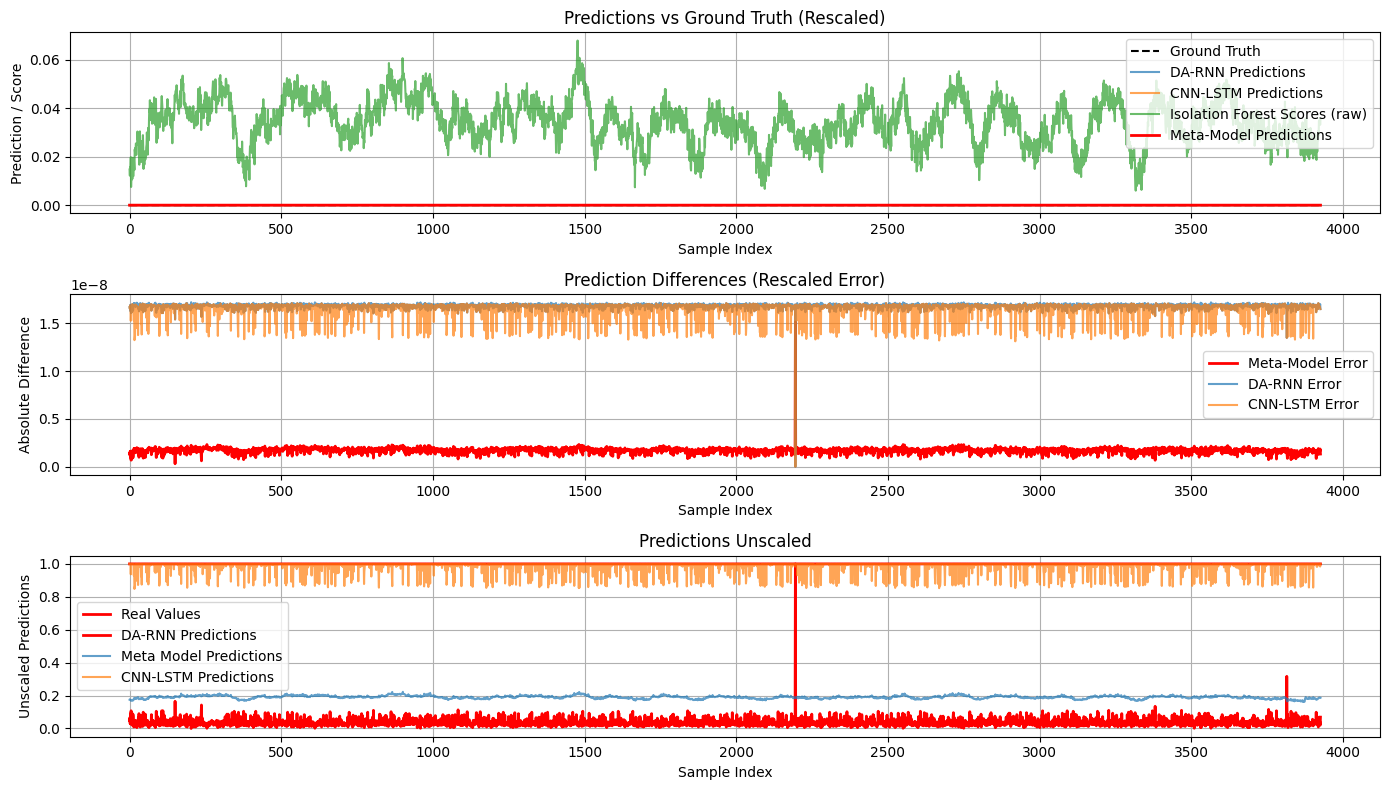

In [ ]:
plot_predictions_with_difference(
    meta_targets=meta_targets,
    da_rnn_preds=da_rnn_preds.flatten(),
    cnn_lstm_preds=cnn_lstm_preds.flatten(),
    iso_forest_scores=iso_forest_scores.flatten(),
    final_predictions=final_predictions,
    inverse_scalers=inverse_scalers,
    ground_truth_max=ground_truth_max,
    ground_truth_min=ground_truth_min
)


## Explanations

Step 3: Explanation of Logic
Current vs. Previous Check:
At every time step, compare the current value with the previous value.
Immediate Flagging:
If the anomaly conditions are met (current > baseline and current - previous > threshold), flag it as an anomaly and stop further checks.
Reset for Next Time Step:
After processing one anomaly, wait for the next time step to repeat the detection.

Step 4: System Output
The system will output either:

Anomaly Detected: If the conditions are satisfied for the current prediction.
Normal: If the conditions are not satisfied.

Advantages of This Approach
Low Latency:
Makes decisions instantly, suitable for real-time systems.
Simple Logic:
Minimal computations per time step.
Handles Multiple Anomalies:
By resetting after detecting an anomaly, the system remains ready for the next anomaly in the stream.

Further Considerations
If anomalies are very frequent and cause many interruptions, we might introduce a cooldown period before checking for another anomaly.